In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.6 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import timm
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os
from torch.cuda.amp import GradScaler, autocast

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Reduce the training set size for faster experimentation
train_size = int(0.1 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Xception Model Setup with `timm`
model_name = 'xception'
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)

# Loss, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
scaler = GradScaler()

# Training, Validation, and Testing
num_epochs = 5
history_xception = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_xception['train_losses'].append(running_loss / len(train_loader))
    history_xception['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_xception['val_losses'].append(val_running_loss / len(val_loader))
    history_xception['val_accuracies'].append(val_correct / len(val_loader.dataset))

    # Testing after each epoch
    test_running_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == labels).sum().item()

    history_xception['test_losses'].append(test_running_loss / len(test_loader))
    history_xception['test_accuracies'].append(test_correct / len(test_loader.dataset))

    print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {history_xception["train_losses"][-1]:.4f}, Val Loss: {history_xception["val_losses"][-1]:.4f}, Test Loss: {history_xception["test_losses"][-1]:.4f}, Train Acc: {history_xception["train_accuracies"][-1]:.4f}, Val Acc: {history_xception["val_accuracies"][-1]:.4f}, Test Acc: {history_xception["test_accuracies"][-1]:.4f}')

    scheduler.step()

# Save the model and history
model_path = f'/content/drive/MyDrive/{model_name}_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/{model_name}_history.pth'
torch.save(history_xception, history_path)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
<ipython-input-9-a1317ba0ed4a>:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-9-a1317ba0ed4a>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type 

xception Epoch 1/5, Train Loss: 0.6998, Val Loss: 0.7136, Test Loss: 0.7075, Train Acc: 0.4937, Val Acc: 0.5306, Test Acc: 0.5300
xception Epoch 2/5, Train Loss: 0.6562, Val Loss: 0.6749, Test Loss: 0.6864, Train Acc: 0.6076, Val Acc: 0.5714, Test Acc: 0.5900
xception Epoch 3/5, Train Loss: 0.6138, Val Loss: 0.6560, Test Loss: 0.6726, Train Acc: 0.6962, Val Acc: 0.5816, Test Acc: 0.6000
xception Epoch 4/5, Train Loss: 0.6044, Val Loss: 0.6436, Test Loss: 0.6629, Train Acc: 0.7215, Val Acc: 0.6735, Test Acc: 0.6300
xception Epoch 5/5, Train Loss: 0.6023, Val Loss: 0.6390, Test Loss: 0.6582, Train Acc: 0.7468, Val Acc: 0.6939, Test Acc: 0.6700


<ipython-input-10-0df9a649b30d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history_xception = torch.load('/content/drive/MyDrive/xception_history.pth')


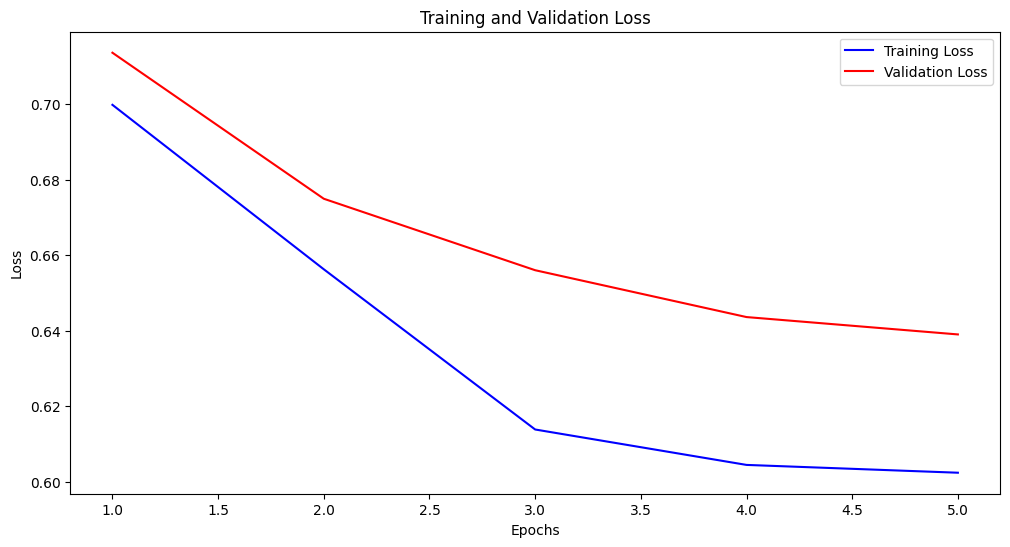

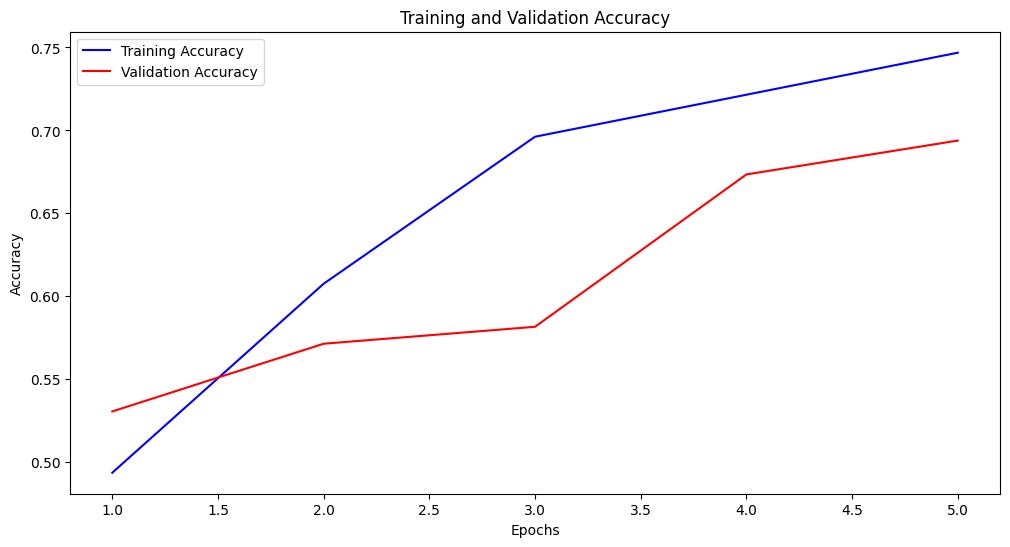

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
<ipython-input-10-0df9a649b30d>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

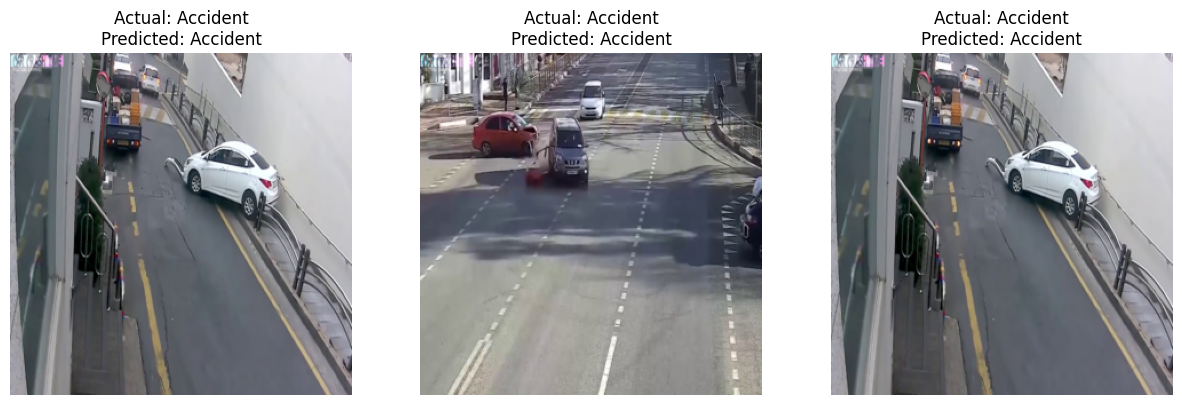

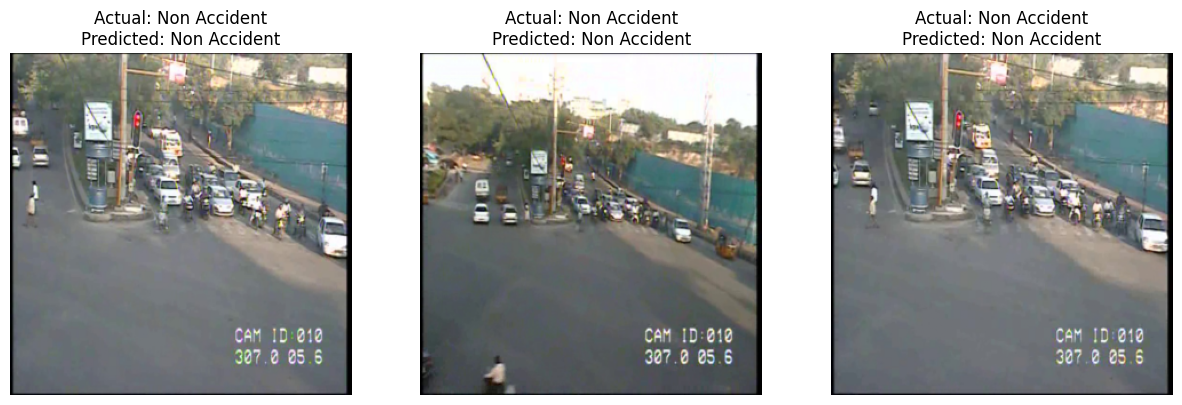

Classification Report:
              precision    recall  f1-score   support

Non Accident       0.64      0.98      0.77        52
    Accident       0.94      0.37      0.53        46

    accuracy                           0.69        98
   macro avg       0.79      0.68      0.65        98
weighted avg       0.78      0.69      0.66        98



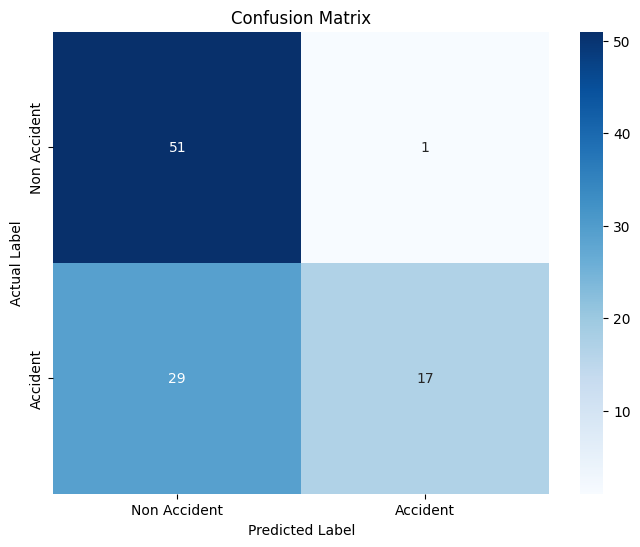

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Load the history for plotting
history_xception = torch.load('/content/drive/MyDrive/xception_history.pth')

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_xception)

# Visualize Correct Predictions on the Validation Set
def visualize_correct_predictions(model, val_loader, num_images=3):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                # Collect correct accident predictions
                if preds[i] == 1 and labels[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                # Collect correct non-accident predictions
                elif preds[i] == 0 and labels[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                # Stop if we have enough images
                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break

            # Stop iterating through the data loader if we have enough images
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Correct Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Correct Non Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model for visualization
model_xception = timm.create_model('xception', pretrained=False, num_classes=1)
model_xception.load_state_dict(torch.load('/content/drive/MyDrive/xception_finetuned.pth'))
model_xception = model_xception.to(device)

# Visualize correct predictions
visualize_correct_predictions(model_xception, val_loader, num_images=3)

# Function to get predictions and true labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Generate Classification Report and Confusion Matrix
preds, labels = get_predictions_and_labels(model_xception, val_loader)

# Classification Report
print("Classification Report:")
print(classification_report(labels, preds, target_names=['Non Accident', 'Accident']))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
cm_df = pd.DataFrame(cm, index=['Non Accident', 'Accident'], columns=['Non Accident', 'Accident'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
